In [0]:
from pyspark.sql.functions import monotonically_increasing_id, desc, length,row_number, col, max as max_, struct
from pyspark.sql.window import Window
from pyspark.mllib.stat import Statistics

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F


In [0]:
#Sales_Train_sets
mainDF = spark.read.csv('/FileStore/tables/sales_train_evaluation.csv', header="true", inferSchema="true")
#Calendar dataset
calendarDF = spark.read.csv('/FileStore/tables/calendar.csv', header="true", inferSchema="true")
#Prices dataset
priceDF = spark.read.csv('/FileStore/tables/sell_prices.csv', header="true", inferSchema="true")



In [0]:
#Grouping the dataframe by grouping by category- Foods, Household and Hobbies
sumDF= mainDF.groupBy('cat_id').sum()
#Transposing the dataframe to get the days as rows and not columns- need to covnert to Pandas DF
sumDF= sumDF.toPandas().set_index("cat_id").transpose().reset_index().rename(columns={'index': 'Day'})
#Converting back to spark dataframe
df= spark.createDataFrame(sumDF)
#Including date in the dataset
w1 = Window.orderBy("Day")
w2= Window.orderBy("Date")

df1 = df.select("*").withColumn("index", row_number().over(w1))
df2=  calendarDF.limit(1941).withColumn("index", row_number().over(w2))

df3= df2.select("Date", "index").join(df1, df1.index== df2.index).select("Date", "FOODS", "HOUSEHOLD", "HOBBIES")
#Grouping the data weekly
df3 = df3.groupBy(F.window(("Date"), "1 week", "1 week")).sum().select("window.start", "window.end" , "sum(FOODS)",'sum(HOBBIES)','sum(HOUSEHOLD)')
df3.show()

+-------------------+-------------------+----------+------------+--------------+
 start| end|sum(FOODS)|sum(HOBBIES)|sum(HOUSEHOLD)|
+-------------------+-------------------+----------+------------+--------------+
2011-01-27 00:00:00|2011-02-03 00:00:00| 100366| 15970| 28692|
2011-02-03 00:00:00|2011-02-10 00:00:00| 162086| 25427| 55090|
2011-02-10 00:00:00|2011-02-17 00:00:00| 175839| 23873| 52820|
2011-02-17 00:00:00|2011-02-24 00:00:00| 171956| 23383| 49900|
2011-02-24 00:00:00|2011-03-03 00:00:00| 162959| 25497| 52510|
2011-03-03 00:00:00|2011-03-10 00:00:00| 147608| 24497| 50053|
2011-03-10 00:00:00|2011-03-17 00:00:00| 141768| 21702| 47814|
2011-03-17 00:00:00|2011-03-24 00:00:00| 183323| 25508| 51289|
2011-03-24 00:00:00|2011-03-31 00:00:00| 168404| 24270| 47764|
2011-03-31 00:00:00|2011-04-07 00:00:00| 161055| 25464| 47908|
2011-04-07 00:00:00|2011-04-14 00:00:00| 133463| 20978| 42993|
2011-04-14 00:00:00|2011-04-21 00:00:00| 158957| 22504| 46452|
2011-04-21 00:00:00|2011-04-28 00:00:00| 180842| 23188| 48188|
2011-04-28 00:00:00|2011-05-05 00:00:00| 173322| 23162| 47091|
2011-05-05 00:00:00|2011-05-12 00:00:00| 154945| 23405| 48920|
2011-05-12 00:00:00|2011-05-19 00:00:00| 149255| 21393| 46253|
2011-05-19 00:00:00|2011-05-26 00:00:00| 159054| 23794| 49023|
2011-05-26 00:00:00|2011-06-02 00:00:00| 177364| 23673| 56155|
2011-06-02 00:00:00|2011-06-09 00:00:00| 169698| 22419| 57028|
2011-06-09 00:00:00|2011-06-16 00:00:00| 144376| 21435| 56033|
+-------------------+-------------------+----------+------------+--------------+
only showing top 20 rows

In [0]:
#Creating 1 dataframe for all
df3w=df3.select('*').withColumnRenamed('start','week_start_date').withColumnRenamed('sum(FOODS)','FOODS').withColumnRenamed('sum(HOBBIES)','HOBBIES').withColumnRenamed('sum(HOUSEHOLD)','HOUSEHOLD').withColumnRenamed('end','week_end_date')
df3w.show()

+-------------------+-------------------+------+-------+---------+
 week_start_date| week_end_date| FOODS|HOBBIES|HOUSEHOLD|
+-------------------+-------------------+------+-------+---------+
2011-01-27 00:00:00|2011-02-03 00:00:00|100366| 15970| 28692|
2011-02-03 00:00:00|2011-02-10 00:00:00|162086| 25427| 55090|
2011-02-10 00:00:00|2011-02-17 00:00:00|175839| 23873| 52820|
2011-02-17 00:00:00|2011-02-24 00:00:00|171956| 23383| 49900|
2011-02-24 00:00:00|2011-03-03 00:00:00|162959| 25497| 52510|
2011-03-03 00:00:00|2011-03-10 00:00:00|147608| 24497| 50053|
2011-03-10 00:00:00|2011-03-17 00:00:00|141768| 21702| 47814|
2011-03-17 00:00:00|2011-03-24 00:00:00|183323| 25508| 51289|
2011-03-24 00:00:00|2011-03-31 00:00:00|168404| 24270| 47764|
2011-03-31 00:00:00|2011-04-07 00:00:00|161055| 25464| 47908|
2011-04-07 00:00:00|2011-04-14 00:00:00|133463| 20978| 42993|
2011-04-14 00:00:00|2011-04-21 00:00:00|158957| 22504| 46452|
2011-04-21 00:00:00|2011-04-28 00:00:00|180842| 23188| 48188|
2011-04-28 00:00:00|2011-05-05 00:00:00|173322| 23162| 47091|
2011-05-05 00:00:00|2011-05-12 00:00:00|154945| 23405| 48920|
2011-05-12 00:00:00|2011-05-19 00:00:00|149255| 21393| 46253|
2011-05-19 00:00:00|2011-05-26 00:00:00|159054| 23794| 49023|
2011-05-26 00:00:00|2011-06-02 00:00:00|177364| 23673| 56155|
2011-06-02 00:00:00|2011-06-09 00:00:00|169698| 22419| 57028|
2011-06-09 00:00:00|2011-06-16 00:00:00|144376| 21435| 56033|
+-------------------+-------------------+------+-------+---------+
only showing top 20 rows

In [0]:
# Define sMAPE
def smape(act,pred): 
    return (100/len(act) * np.sum(2 * np.abs(pred - act) / (np.abs(act) + np.abs(pred))))

In [0]:
#adding weeks column
df3w = df3w.withColumn('week',monotonically_increasing_id())

Food Section

1. Weekly Data split

Using the values at the exact same date for the previous year

In [0]:
#Creating new column with a lag of 1 year
w_lag = Window.orderBy('week_start_date')
df3n=df3w.withColumn('lag_feature', F.lag(F.col('FOODS'),52).over(w_lag))
df3n=df3n.na.drop()
#Checking only for the last 20 weeks
df3_X=df3n.select('FOODS').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3n.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('FOODS').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 

print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))


RMSE: 25791.565
SMAPE: 12.871681918304674

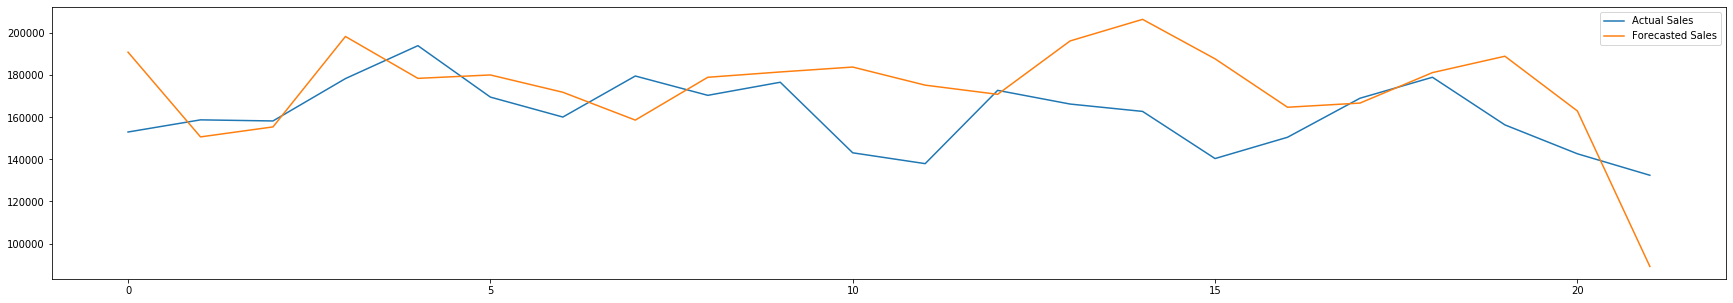

In [0]:
#Plotting the graph
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous month (4 weeks)

In [0]:
#Creating new column with a lag of 1 month
w_lag = Window.orderBy('week_start_date')
df3n=df3w.withColumn('lag_feature', F.lag(F.col('FOODS'),4).over(w_lag))
df3n=df3n.na.drop()
df3_X=df3n.select('FOODS').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3n.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('FOODS').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 24791.130
SMAPE: 10.801977099016598

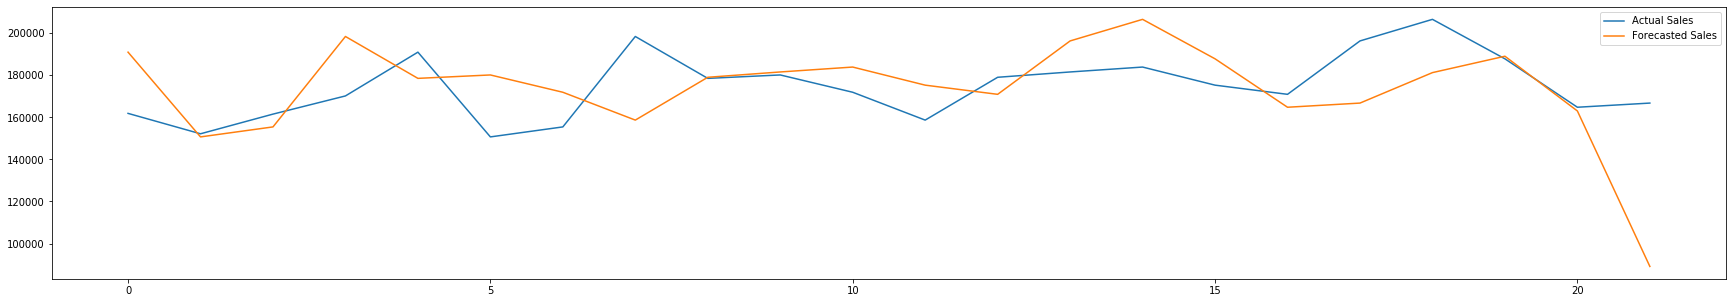

In [0]:
# plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous 2 weeks

In [0]:
#Creating new column with a lag of 2 week
w_lag = Window.orderBy('week_start_date')
df3n=df3w.withColumn('lag_feature', F.lag(F.col('FOODS'),2).over(w_lag))
df3n=df3n.na.drop()
df3_X=df3n.select('FOODS').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3n.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('FOODS').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 31638.935
SMAPE: 14.595775485677668

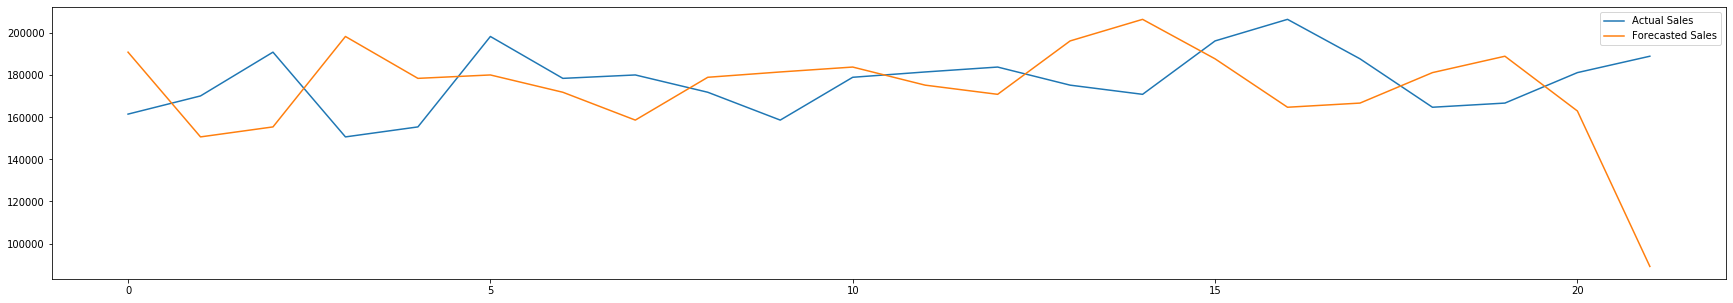

In [0]:
# plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous week

In [0]:
#Creating new column with a lag of 1 week
w_lag = Window.orderBy('week_start_date')
df3n=df3w.withColumn('lag_feature', F.lag(F.col('FOODS'),1).over(w_lag))
df3n=df3n.na.drop()
df3_X=df3n.select('FOODS').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3n.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('FOODS').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 24431.253
SMAPE: 10.786535426550886

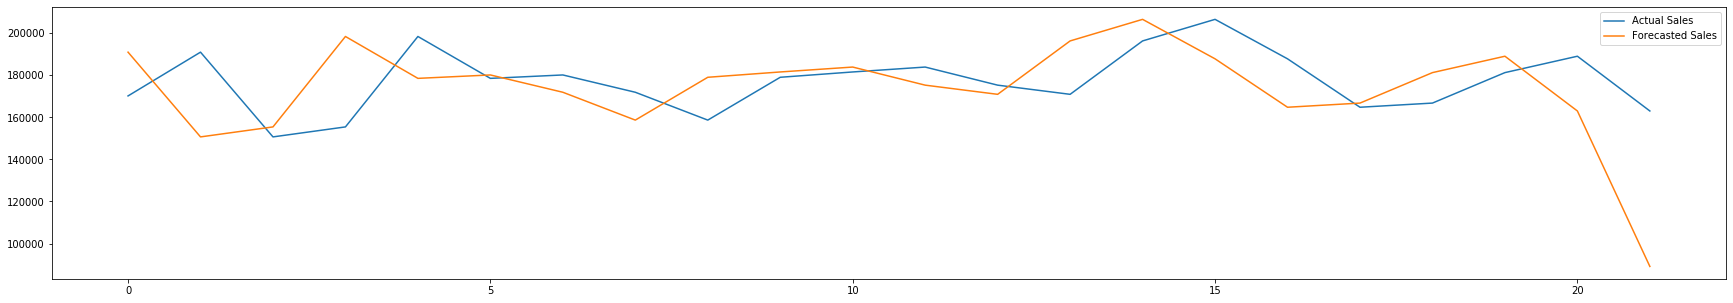

In [0]:
# plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Hobbies Section

Using the values at the exact same date for the previous year

In [0]:
#Creating new column with a lag of 1 year
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOBBIES'),52).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOBBIES').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOBBIES').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 5896.806
SMAPE: 27.280152457650573

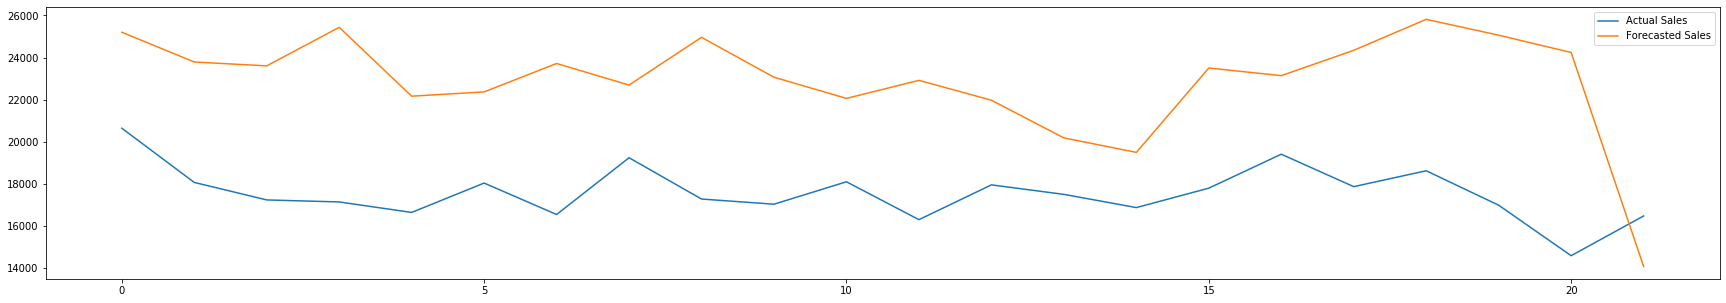

In [0]:
#plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous month ( 4 weeks )

In [0]:
#Creating new column with a lag of 1 month
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOBBIES'),4).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOBBIES').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOBBIES').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 3221.553
SMAPE: 10.446116081491462

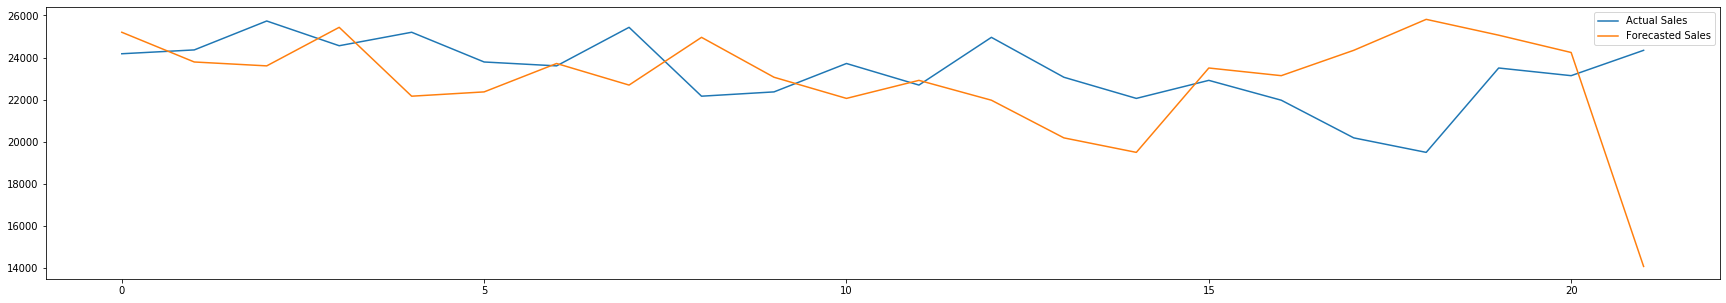

In [0]:
#plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous 2 weeks

In [0]:
#Creating new column with a lag of 2 week
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOBBIES'),2).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOBBIES').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOBBIES').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 3012.894
SMAPE: 9.21075280270474

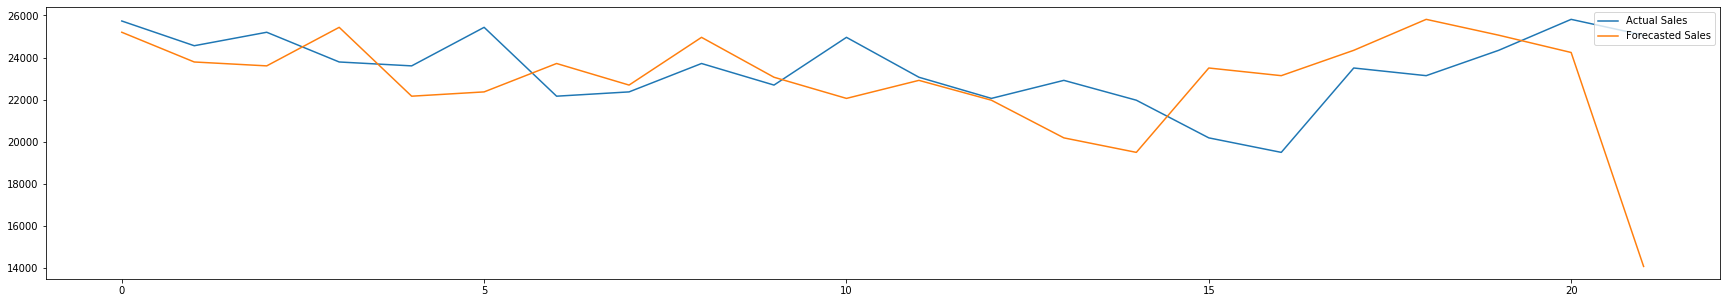

In [0]:
# plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous week

In [0]:
#Creating new column with a lag of 1 week
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOBBIES'),1).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOBBIES').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOBBIES').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 2686.659
SMAPE: 7.900900722753485

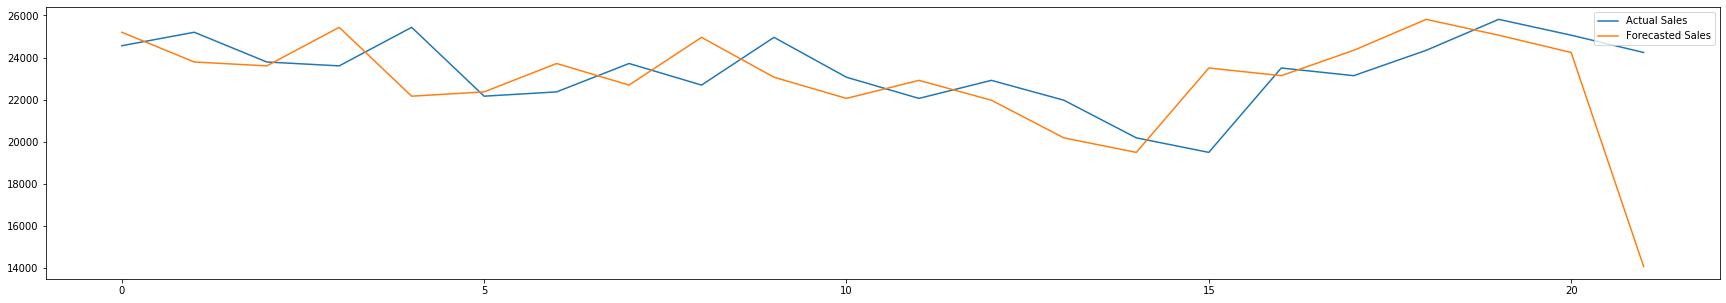

In [0]:
#plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Household Section

Using the values at the exact same date for the previous year

In [0]:
#Creating new column with a lag of 1 year
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOUSEHOLD'),52).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOUSEHOLD').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOUSEHOLD').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 7458.949
SMAPE: 12.490711873931202

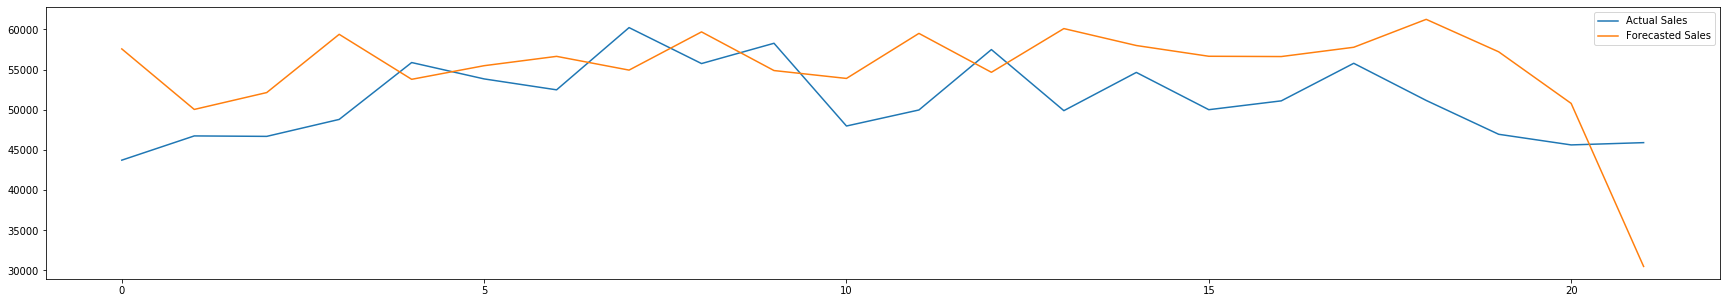

In [0]:
#plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values at the exact same date for the previous month ( 4 weeks)

In [0]:
#Creating new column with a lag of 1 month
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOUSEHOLD'),4).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOUSEHOLD').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOUSEHOLD').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 7235.990
SMAPE: 9.445774534384192

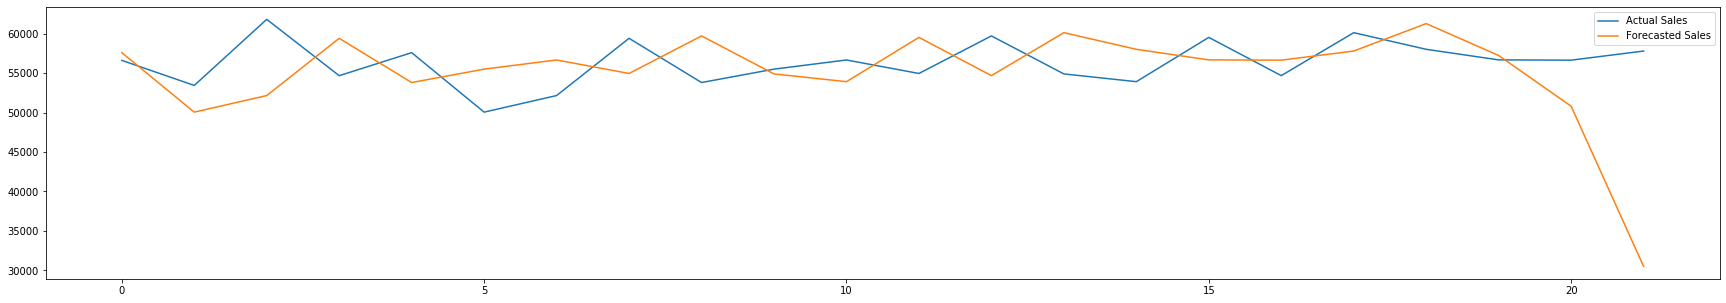

In [0]:
#plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous 2 Weeks

In [0]:
#Creating new column with a lag of 2 week
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOUSEHOLD'),2).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOUSEHOLD').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOUSEHOLD').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 7132.061
SMAPE: 8.617855921420933

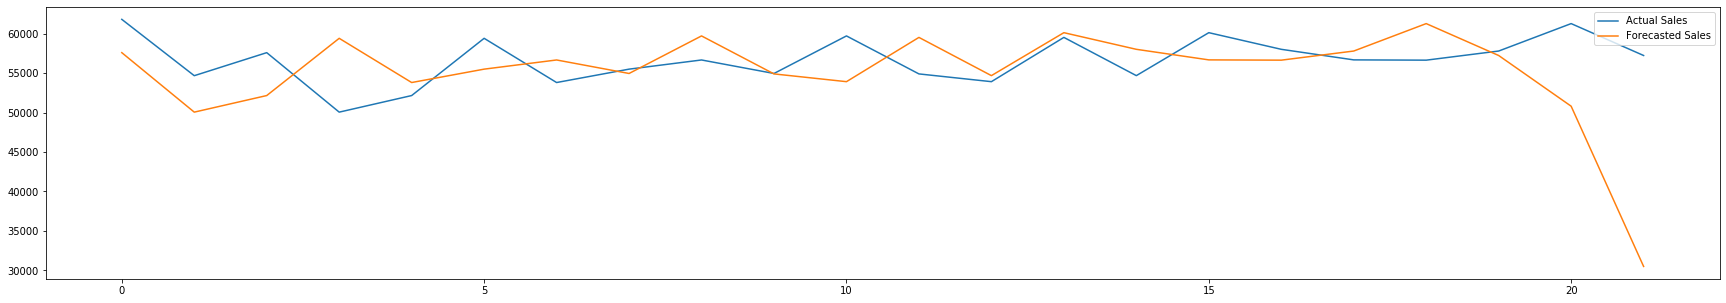

In [0]:
# plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()

Using the values for the previous Week

In [0]:
#Creating new column with a lag of 1 week
w_lag = Window.orderBy('week_start_date')
df3h=df3w.withColumn('lag_feature', F.lag(F.col('HOUSEHOLD'),1).over(w_lag))
df3h=df3h.na.drop()
df3_X=df3h.select('HOUSEHOLD').where(F.col('week')>=256).orderBy('week_start_date')
df3_Y=df3h.select('lag_feature').where(F.col('week')>=256).orderBy('week_start_date')

In [0]:
#Finding RMSE and sMape
import matplotlib.pyplot as plt
predictions=[]
for x in df3_X.select('HOUSEHOLD').rdd.flatMap(lambda x: x).collect():
	predictions.append(x)
actual=df3_Y.select('lag_feature').rdd.flatMap(lambda x: x).collect()
test_score = sqrt(mean_squared_error(actual, predictions))
preds, act = np.array(predictions), np.array(actual) 
print('RMSE: %.3f' % test_score)
print('SMAPE: ',smape(act,preds))

RMSE: 5959.036
SMAPE: 8.330089572377405

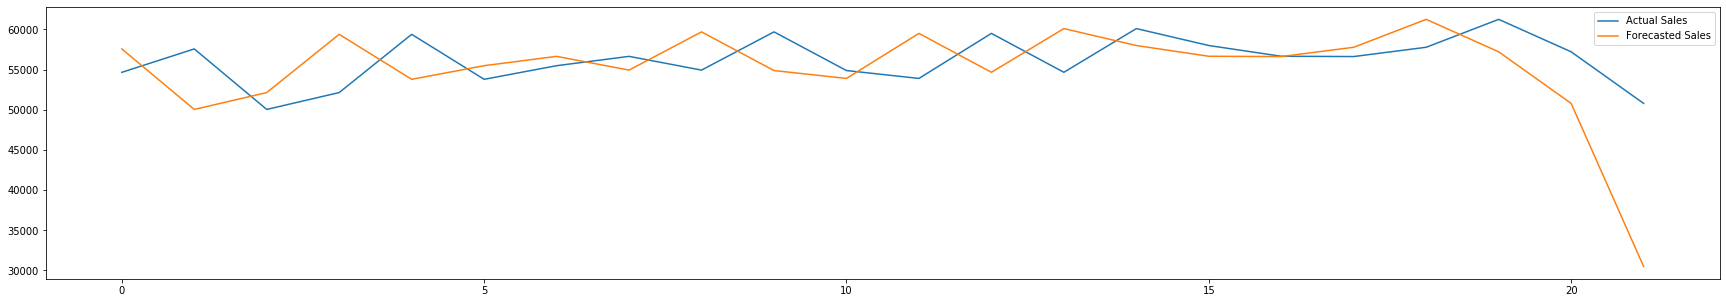

In [0]:
#plotting the figure
plt.figure(figsize=(30,5))
plt.plot(df3_Y.select('lag_feature').limit(400).rdd.flatMap(lambda x: x).collect() )
plt.plot(predictions[0:400])
plt.legend(['Actual Sales', 'Forecasted Sales'], loc='upper right')
pyplot.show()